In [18]:
import json
import os
from dotenv import load_dotenv
from chatsky_llm_autoconfig.algorithms.base import GraphExtender
from chatsky_llm_autoconfig.dialogue import Dialogue, DialogueMessage
from chatsky_llm_autoconfig.graph import Graph, BaseGraph

from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
load_dotenv()

True

Gonna test extension of such a dialogue in a library:

- U: Hello
- A: Hello, how can I help?
- U: I want to take a book
- A: Which author are you interested in?
- U: Arseniy Tarkovsky
- A: Here you are

and we will attach to it this dialogue

- U: Hello
- A: Hello, how can I help?
- U: I want to take a magazine
- A: Which magazine are you interested in?
- U: Vogue
- A: Which period are you interested in?
- U: October 1987
- A: Here you are


In [12]:
original_dialogue = Dialogue(messages=[
    # DialogueMessage(text="Hello", participant="user"),
    DialogueMessage(text="Hello, how can I help?", participant="assistant"),
    DialogueMessage(text="I want to take a book", participant="user"),
    DialogueMessage(text="Which author are you interested in?", participant="assistant"),
    DialogueMessage(text="Arseniy Tarkovsky", participant="user"),
    DialogueMessage(text="Here you are", participant="assistant"),
])

additional_dialogue = Dialogue(messages=[
    # DialogueMessage(text="Hello", participant="user"),
    DialogueMessage(text="Hello, how can I help?", participant="assistant"),
    DialogueMessage(text="I want to take a magazine", participant="user"),
    DialogueMessage(text="Which magazine are you interested in?", participant="assistant"),
    DialogueMessage(text="Vogue", participant="user"),
    DialogueMessage(text="Which period are you interested in?", participant="assistant"),
    DialogueMessage(text="October 1987", participant="user"),
    DialogueMessage(text="Here you are", participant="assistant"),
])

In [14]:
original_graph = Graph(graph_dict={
    "nodes": [
        {
            "id": 1,
            "label": "start",
            "is_start": True,
            "utterances": [
                "Hello, how can I help?"
            ]
        },
        {
            "id": 2,
            "label": "ask_author",
            "is_start": False,
            "utterances": [
                "Which author are you interested in?"
            ]
        },
        {
            "id": 3,
            "label": "end",
            "is_start": False,
            "utterances": [
                "Here you are"
            ]
        },
    ],
    "edges": [
        {
            "utterances": [
                "I want to take a book"
            ],
            "source": 1,
            "target": 2
        },
        {
            "utterances": [
                "Arseniy Tarkovsky"
            ],
            "source": 2,
            "target": 3
        },
    ]
})

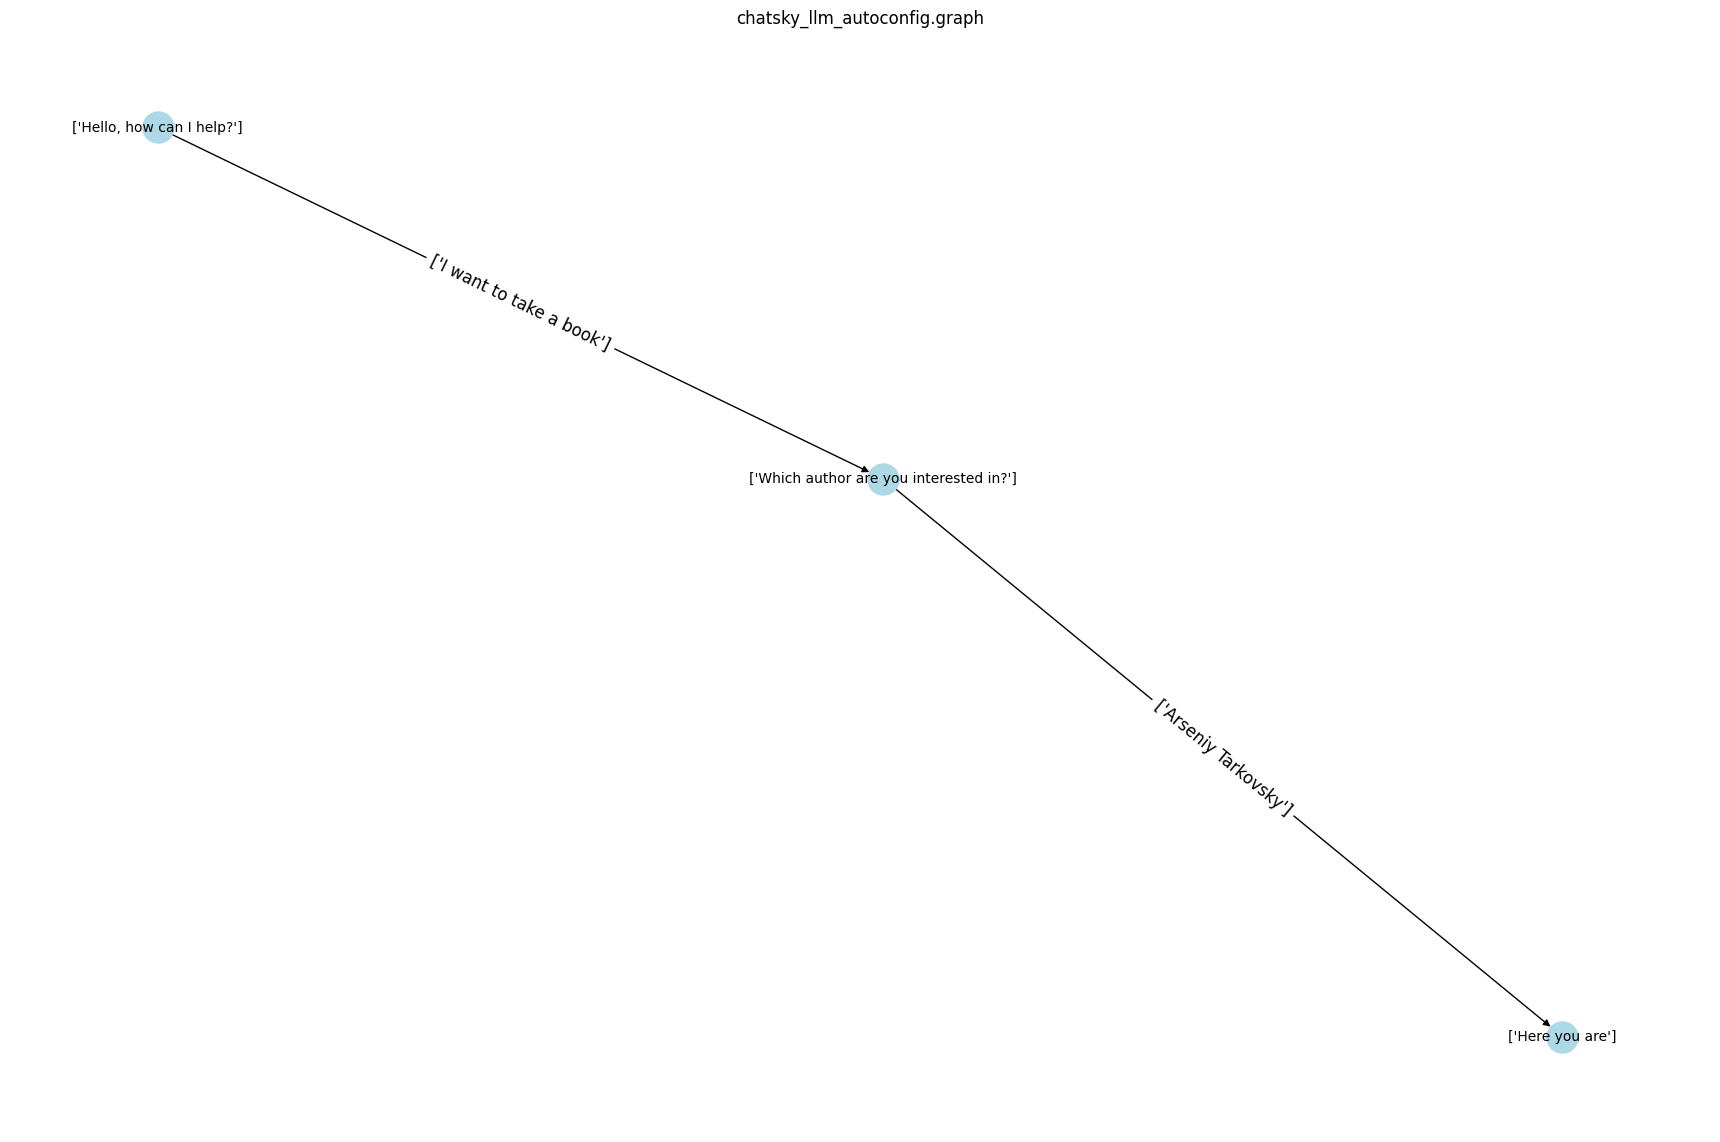

In [15]:
original_graph.visualise()

In [29]:
class AppendChain(GraphExtender):
    prompt: str = ""
    def __init__(self):
        super().__init__()
        self.prompt = PromptTemplate.from_template(
            """
            You will be given a dialogue and a graph that describes this dialogue: edges' utterances are corresponding to users requests and nodes' utterances are corresponding to assistants' responses. You will also be given with another branch of this dialogue. You tasks are so:
            1. Determine which parts of the dialogues are the same and which are different.
            2. Append the brach defined by second dialogue to the graph -- add corresponding edges and nodes to the graph.
            3. Return graph that describes both dialogues.
            
            **Rules:**
            1) Responses must acknowledge what the user has already specified
            2) Each node must have clear purpose
            3) Return ONLY the JSON without commentary and codeblocks
            4) All edges must connect to existing nodes
            5) The graph paths should make logical sense
            6) Nodes and edges that bears same meaning must not be duplicated, reuse them when possible
            7) If nodes has same uterances the should be merged into one
            
            Original dialogue: {orig_dial}
            Original graph: {orig_graph}

            Additional branch: {new_dial}

            """
        )

    def invoke(self, dialogue: Dialogue, graph: BaseGraph) -> BaseGraph:
        # parser = JsonOutputParser(pydantic_object=DialogueGraph)
        model = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"), base_url=os.getenv("OPENAI_BASE_URL"), temperature=0)
        chain = self.prompt | model
        generated_graph = chain.invoke({"orig_dial": original_dialogue, "orig_graph": original_graph.graph_dict, "new_dial": additional_dialogue})

        return Graph(graph_dict=json.loads(generated_graph.content))

    async def ainvoke(self, dialogue: Dialogue, graph: BaseGraph) -> BaseGraph:
        raise NotImplementedError


In [30]:
appender = AppendChain()

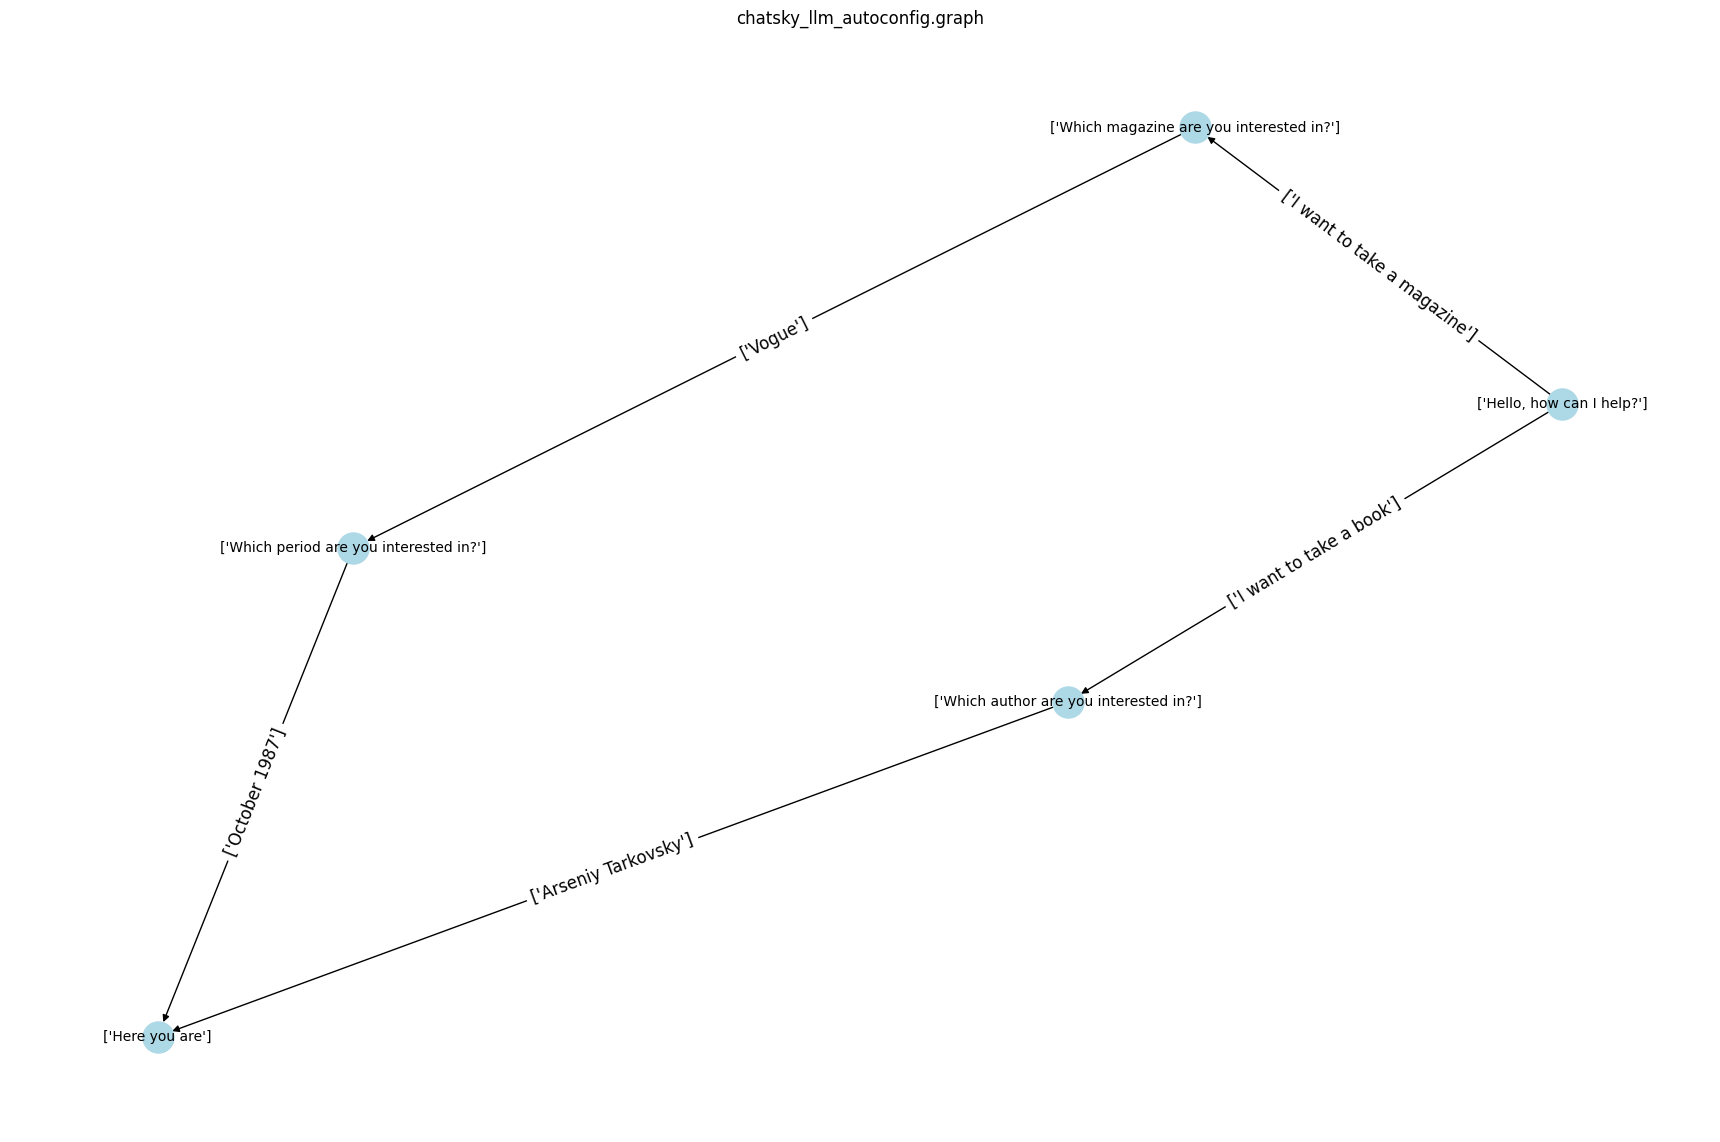

In [31]:
new_graph = appender.invoke(original_dialogue, original_graph)
new_graph.visualise()